## 1. Import Requirements

In [12]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

np.random.seed(5)


## 2. Loading the Dataset and Preprocessing

##### 2.a Establish Important Variables

In [13]:
train_dir = 'asl_alphabet_train/asl_alphabet_train'
test_dir = 'asl_alphabet_test/asl_alphabet_test'
img_size = 64

##### 2.b Function for parsing the images into a vector 

In [14]:
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
    'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13,
    'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20,
    'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25,
    'nothing': 26, 'space': 27, 'del': 28
}

# responsible for parsing the images to vectors
def load_images_from_folder(folder):
    images = []
    labels = []

    for label in os.listdir(folder):
        print("Parsing label: " + label)
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder) and label in label_mapping:
            label_index = label_mapping[label]  # Get the corresponding index
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                    img_resized = cv2.resize(img_gray, (img_size, img_size))  # Resize to a fixed size
                    images.append(img_resized.flatten())  # Flatten the image
                    labels.append(label_index)  # Use the mapped index for the label

    return np.array(images), np.array(labels)

# converts a given y value to the recorresponding label
def find_label_of_int(value):
    dict = { 26: "nothing", 27: "space", 28: "del" }

    if 0 <= value <= 25:
        return chr(value + ord('A'))  # Convert 0-25 to 'A'-'Z'
    elif value <= 28:
        return dict[value]

##### 2.c Parse the images and split to train and validation

In [15]:
x_train, y_train = load_images_from_folder(train_dir)

Parsing label: A
Parsing label: B
Parsing label: C
Parsing label: D
Parsing label: del
Parsing label: E
Parsing label: F
Parsing label: G
Parsing label: H
Parsing label: I
Parsing label: J
Parsing label: K
Parsing label: L
Parsing label: M
Parsing label: N
Parsing label: nothing
Parsing label: O
Parsing label: P
Parsing label: Q
Parsing label: R
Parsing label: S
Parsing label: space
Parsing label: T
Parsing label: U
Parsing label: V
Parsing label: W
Parsing label: X
Parsing label: Y
Parsing label: Z


In [16]:
print("X Train Shape: ", x_train.shape)
print("Y Train Shape: ", y_train.shape)


X Train Shape:  (87000, 4096)
Y Train Shape:  (87000,)


In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print("X Train Shape: ", x_train.shape)
print("Y Train Shape: ", y_train.shape)
print("X Val Shape: ", x_val.shape)
print("Y Val Shape: ", y_val.shape)

##### 2.d visualize and examine the dataset

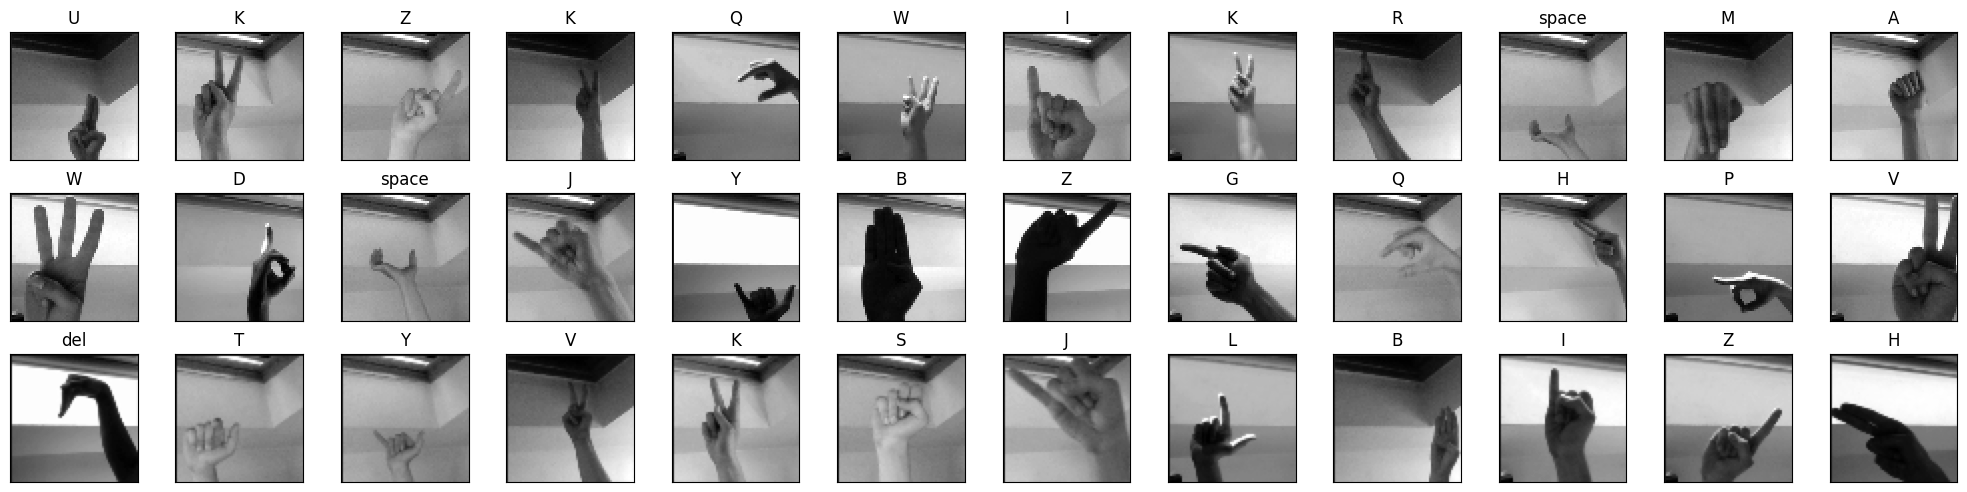

In [18]:
# Store labels of dataset
labels = ['nothing', 'space', 'del'] + [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20, 5))
for i in range(36):  # Display first 36 images
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    
    # Reshape the flattened image back to (img_size, img_size)
    img_reshaped = x_train[i].reshape(img_size, img_size)
    
    ax.imshow(img_reshaped, cmap='gray')  # Display in grayscale
    ax.set_title("{}".format(find_label_of_int(y_train[i])))

plt.tight_layout()
plt.show()

Check if balanced

In [19]:
# The dataset is quite balanced!
print("Train/test samples per class:")
for i, label in enumerate(label_mapping):
    num_train = sum(y_train==i)
    num_test = sum(y_val==i)
    print(f"{label}: {num_train} / {num_test} = {round(num_train/num_test, 2)}")

Train/test samples per class:
A: 2416 / 584 = 4.14
B: 2426 / 574 = 4.23
C: 2383 / 617 = 3.86
D: 2411 / 589 = 4.09
E: 2420 / 580 = 4.17
F: 2415 / 585 = 4.13
G: 2413 / 587 = 4.11
H: 2401 / 599 = 4.01
I: 2402 / 598 = 4.02
J: 2390 / 610 = 3.92
K: 2391 / 609 = 3.93
L: 2359 / 641 = 3.68
M: 2374 / 626 = 3.79
N: 2413 / 587 = 4.11
O: 2431 / 569 = 4.27
P: 2397 / 603 = 3.98
Q: 2414 / 586 = 4.12
R: 2351 / 649 = 3.62
S: 2429 / 571 = 4.25
T: 2340 / 660 = 3.55
U: 2381 / 619 = 3.85
V: 2432 / 568 = 4.28
W: 2420 / 580 = 4.17
X: 2404 / 596 = 4.03
Y: 2416 / 584 = 4.14
Z: 2421 / 579 = 4.18
nothing: 2432 / 568 = 4.28
space: 2320 / 680 = 3.41
del: 2398 / 602 = 3.98


## 3. Training using different techniques

Initialize the models

In [20]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

Train each model

In [21]:
# Decision Trees
print("Training: ", "Decision Tree")
models["Decision Tree"].fit(x_train, y_train)

Training:  Decision Tree


DecisionTreeClassifier(random_state=42)

In [22]:
# Random Forest
print("Training: ", "Random Forest")
models["Random Forest"].fit(x_train, y_train)

Training:  Random Forest


RandomForestClassifier(random_state=42)

In [23]:
# K-Nearest Neighbors
print("Training: ", "K-Nearest Neighbors")
models["K-Nearest Neighbors"].fit(x_train, y_train)

Training:  K-Nearest Neighbors


KNeighborsClassifier()

In [24]:
# Naive Bayes
print("Training: ", "Naive Bayes")
models["Naive Bayes"].fit(x_train, y_train)

Training:  Naive Bayes


GaussianNB()

In [32]:
# Support Vector Machine
print("Training: ", "Support Vector Machine")
models["Support Vector Machine"].fit(x_train, y_train)

Training:  Support Vector Machine


SVC(random_state=42)

In [33]:
# Logistic Regression
print("Training: ", "Logistic Regression")
models["Logistic Regression"].fit(x_train, y_train)

Training:  Logistic Regression


C:\Users\ron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

Predict and produce a confusion matrix for each model

In [36]:
confusion_matrices = {}

for model_name, model in models.items():
    y_pred = model.predict(x_val)
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices[model_name] = cm

Plot

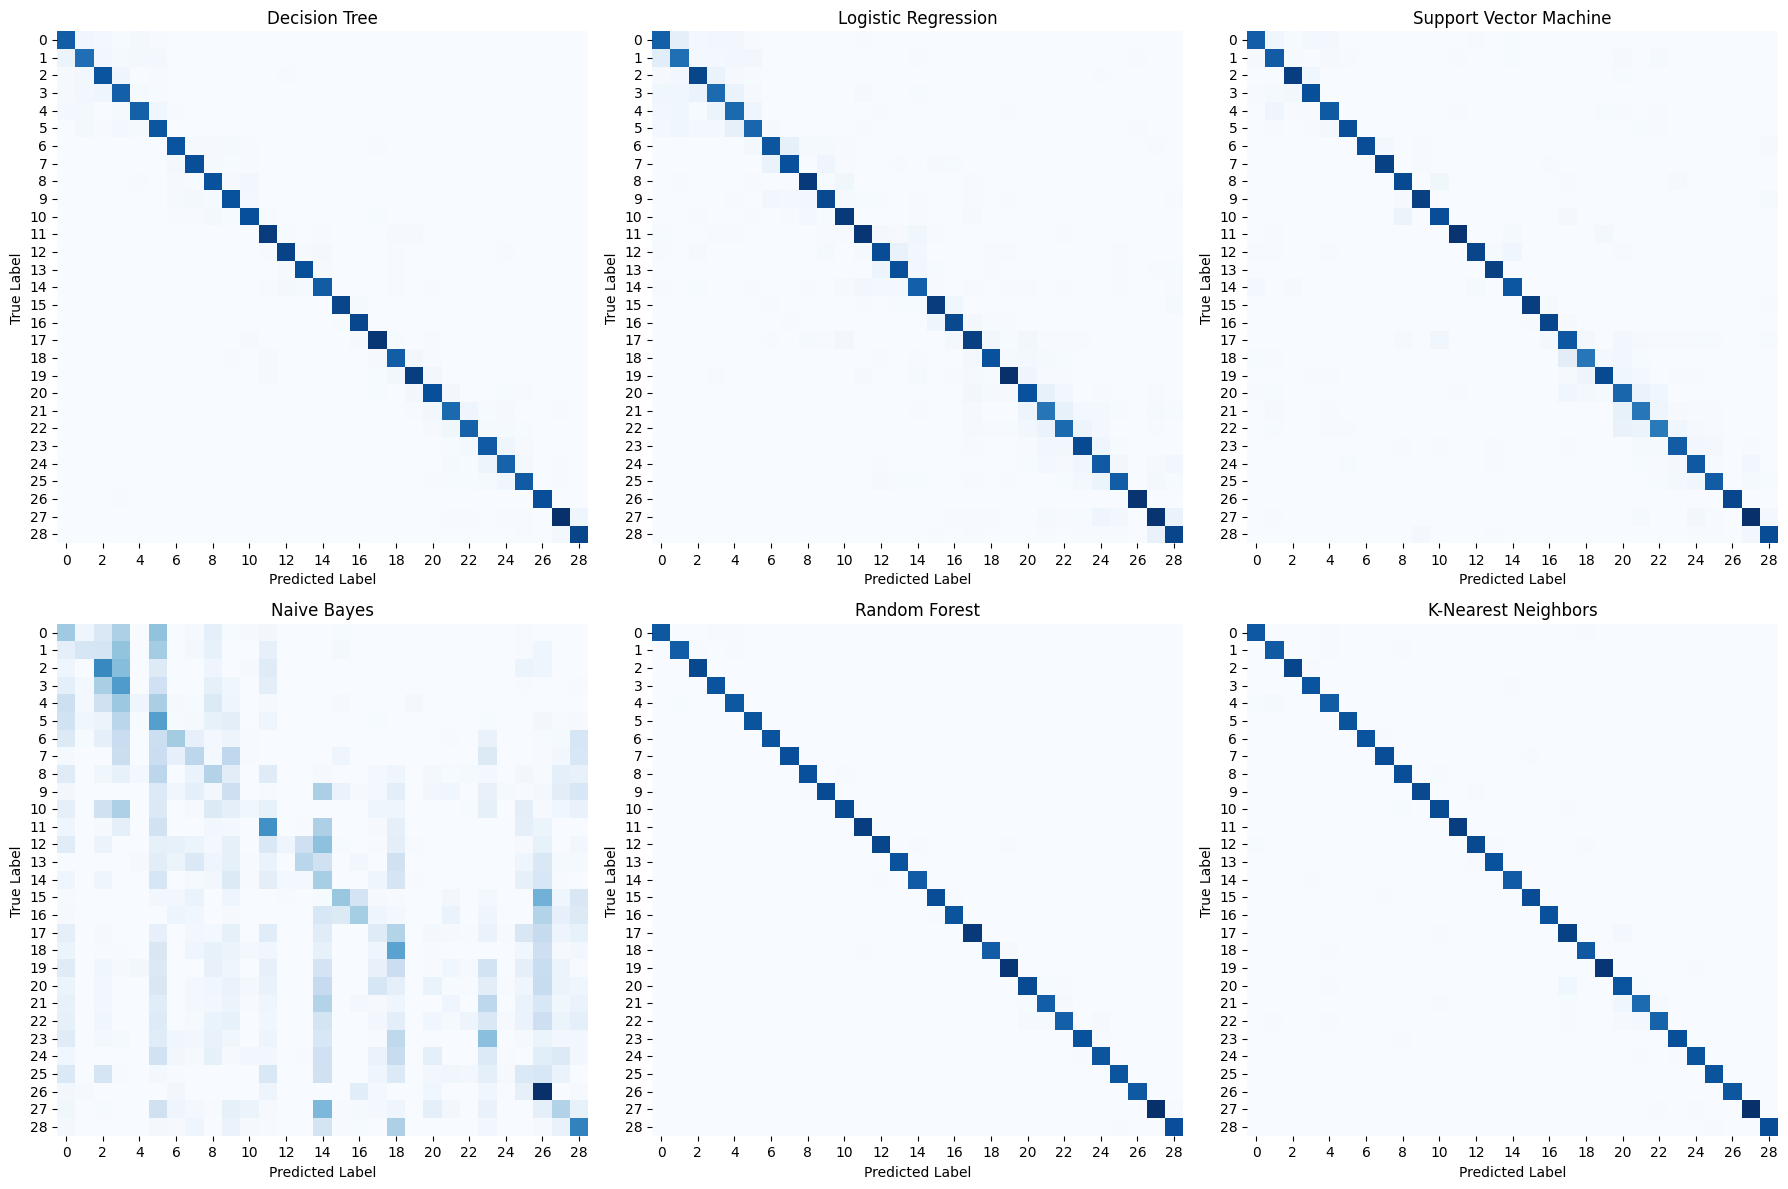

In [37]:
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust grid size as needed
axes = axes.ravel()  # Flatten the array for easy indexing

for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{model_name}")
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Summarize the finding

In [31]:
summary = []
for model_name, model in models.items():
    y_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    summary.append({"Model": model_name, "Accuracy": accuracy})

summary_df = pd.DataFrame(summary)
print("\nSummary of Model Performance:")
print(summary_df)


Summary of Model Performance:
                 Model  Accuracy
0        Decision Tree  0.912874
1          Naive Bayes  0.206034
2        Random Forest  0.990402
3  K-Nearest Neighbors  0.978736


## 4. Test on custom Data

## 5. Improve